## BoW baseline
Computing baselines (training tokenizer on first 10 batches) on 50 batches.

### Imports

In [1]:
import gzip
import json
from keras.preprocessing.text import Tokenizer
import glob
import numpy as np
from multiprocessing import Pool
import itertools
import spacy
import pandas as pd
import random
import os
import seaborn as sns
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
sns.set_style("whitegrid")

### Set up parameters

In [3]:
fs = glob.glob('../reddit/data/json/triplet/1pos_1neg_random/train/*') 

In [4]:
t_posts = []
for f in fs[:10]:
    t_data = json.load(gzip.open(f))
    for t in t_data:
        t_posts += t['anchor']
        t_posts += t['negative']
        t_posts += t['positive']
t_posts = [' '.join(t.split(' ')[:400]) for t in t_posts]

In [5]:
def edist(v1, v2):
    ''' Compute euclidean distance '''
    return np.mean(np.sum(np.square(np.abs(v1-v2)), axis=1))

In [6]:
def mandist(v1, v2):
    ''' Compute manhattan distance '''
    return np.mean(np.sum(np.abs(v1-v2), axis=1))

In [7]:
def run_bow(f, tokenizer, 
            metric='euclidean', 
            mode='count',
            subset=False):
    metrics = []
    lst = json.load(gzip.open(f))
    for l in lst:
        anchs = [' '.join(p.split(' ')[:400]) for p in l['anchor']]
        ps = [' '.join(p.split(' ')[:400]) for p in l['positive']]
        ns = [' '.join(p.split(' ')[:400]) for p in l['negative']]
        if subset is not False:
            random.shuffle(anchs)
            anchs = anchs[:subset]
        l_enc = tokenizer.texts_to_matrix(anchs, mode=mode)
        l_enc_p = tokenizer.texts_to_matrix(ps, mode=mode)
        l_enc_n = tokenizer.texts_to_matrix(ns, mode=mode)
        l_enc = np.mean(l_enc, axis=0)
        if metric == 'euclidean':
            avg_pos = edist(l_enc, l_enc_p)
            avg_neg = edist(l_enc, l_enc_n)
        elif metric == 'manhattan':
            avg_pos = mandist(l_enc, l_enc_p)
            avg_neg = mandist(l_enc, l_enc_n)
        else:
            raise ValueError('Metric distance unknown')
        metrics.append(int(avg_neg>avg_pos))
    return metrics

### Run BoW baseline (metric distance)

In [8]:
num_words = [100, 1000, 5000]
mdists = ['euclidean', 'manhattan']
modes = ["binary", "count", "tfidf", "freq"]
subset = [1] # None, 10, 20]

In [9]:
params = list(itertools.product(num_words, 
                                mdists, 
                                modes, 
                                subset))

In [13]:
results = []
for p in params:
    print(f'Running BoW, {p[0], p[1], p[2]}')
    pool = Pool(19)
    tokenizer = Tokenizer(num_words=p[0])
    tokenizer.fit_on_texts(t_posts)
    res = pool.starmap(run_bow, zip(fs[10:60],
                                    [tokenizer] * 50,
                                    [p[1]] * 50,
                                    [p[2]] * 50,
                                    [p[3]] * 50))
    chain_res =  list(itertools.chain(*res))
    results.append((p[0], p[1], p[2], p[3],
                    np.sum(chain_res) / len(chain_res)))
    pd.DataFrame(results, columns=['words', 'metric',
                                   'mode', 'subset',
                                   'performance']).to_csv('triplet_baseline_data/bow_avg_enc_1post.txt', 
                                                          sep='\t')
    pool.close()
    pool.join()

Running BoW, (100, 'euclidean', 'binary')
Running BoW, (100, 'euclidean', 'count')
Running BoW, (100, 'euclidean', 'tfidf')
Running BoW, (100, 'euclidean', 'freq')
Running BoW, (100, 'manhattan', 'binary')
Running BoW, (100, 'manhattan', 'count')
Running BoW, (100, 'manhattan', 'tfidf')
Running BoW, (100, 'manhattan', 'freq')
Running BoW, (1000, 'euclidean', 'binary')
Running BoW, (1000, 'euclidean', 'count')
Running BoW, (1000, 'euclidean', 'tfidf')
Running BoW, (1000, 'euclidean', 'freq')
Running BoW, (1000, 'manhattan', 'binary')
Running BoW, (1000, 'manhattan', 'count')
Running BoW, (1000, 'manhattan', 'tfidf')
Running BoW, (1000, 'manhattan', 'freq')
Running BoW, (5000, 'euclidean', 'binary')
Running BoW, (5000, 'euclidean', 'count')
Running BoW, (5000, 'euclidean', 'tfidf')
Running BoW, (5000, 'euclidean', 'freq')
Running BoW, (5000, 'manhattan', 'binary')
Running BoW, (5000, 'manhattan', 'count')
Running BoW, (5000, 'manhattan', 'tfidf')
Running BoW, (5000, 'manhattan', 'freq')


### Other baselines

#### Pretrained word vectors

In [22]:
def run_w2v(f, metric='euclidean', subset=False):
    metrics = []
    w2v = spacy.load('en_core_web_md')
    lst = json.load(gzip.open(f))
    for idx, l in enumerate(lst):
        try:
            anchs = [' '.join(p.split(' ')[:400]) for p in l['anchor']]
            ps = [' '.join(p.split(' ')[:400]) for p in l['positive']]
            ns = [' '.join(p.split(' ')[:400]) for p in l['negative']]
            if subset is not False:
                random.shuffle(anchs)
                anchs = anchs[:subset]
            l_enc = np.array([w2v(s).vector for s in anchs])
            l_enc_p = np.array([w2v(s).vector for s in ps])
            l_enc_n = np.array([w2v(s).vector for s in ns])
            if l_enc.shape[0] > 1:
                l_enc = np.mean(l_enc, axis=0)
            if metric == 'euclidean':
                avg_pos = edist(l_enc, l_enc_p)
                avg_neg = edist(l_enc, l_enc_n)
            elif metric == 'manhattan':
                avg_pos = mandist(l_enc, l_enc_p)
                avg_neg = mandist(l_enc, l_enc_n)
            else:
                raise ValueError('Metric distance unknown')
            metrics.append(int(avg_neg>avg_pos))
            del l_enc, l_enc_p, l_enc_n, avg_pos, avg_neg, anchs, ps, ns
        except:
            pass
    return metrics

In [23]:
w2vparams = list(itertools.product(mdists, 
                                   subset)) # [1:]

In [24]:
results_w2v = []
for p in w2vparams:
    print(f'Running Word2Vec, {p[0], p[1]}')
    pool = Pool(20)
    res = pool.starmap(run_w2v, zip(fs[10:60],
                                    [p[0]] * 50,
                                    [p[1]] * 50))
    chain_res =  list(itertools.chain(*res))
    results_w2v.append((p[0], p[1], 
                        np.sum(chain_res) / len(chain_res)))
    pd.DataFrame(results_w2v, columns=['metric', 
                                       'subset',
                                       'performance']).to_csv('triplet_baseline_data/w2v_avg_enc_1post.txt', 
                                                              sep='\t')
    pool.close()
    pool.join()

Running Word2Vec, ('euclidean', 1)
Running Word2Vec, ('manhattan', 1)


### Final notes

In [55]:
bow_avg = pd.read_csv('triplet_baseline_data/bow_avg_enc.txt', sep='\t', index_col=0)
w2v_avg = pd.read_csv('triplet_baseline_data/w2v_avg_enc.txt', sep='\t', index_col=0)
bow_avg_1 = pd.read_csv('triplet_baseline_data/bow_avg_enc_1post.txt', sep='\t', index_col=0)
w2v_avg_1 = pd.read_csv('triplet_baseline_data/w2v_avg_enc_1post.txt', sep='\t', index_col=0)
# Merge and subset

In [56]:
bow_avg = pd.concat([bow_avg, bow_avg_1], ignore_index=True)
w2v_avg = pd.concat([w2v_avg, w2v_avg_1], ignore_index=True)

In [57]:
w2v_avg['subset'] = w2v_avg['subset'].replace({np.nan: 'all'})
w2v_avg = w2v_avg[w2v_avg['subset'].isin([1,10])]
w2v_avg['model'] = 'Word2Vec'
w2v_avg['id'] = 'W2Vec_' + w2v_avg['metric']

In [58]:
bow_avg['subset'] = bow_avg['subset'].replace({np.nan: 'all'})
bow_avg = bow_avg[bow_avg['subset'].isin([1,10])]
bow_avg['model'] = 'BoW'
bow_avg['id'] = 'BoW_' + bow_avg['metric'] + '_' + \
                bow_avg['mode'] + '_' + bow_avg['words'].astype(str)

In [59]:
perf = pd.concat([d[['id', 'model',
                     'subset',
                     'metric',
                     'performance']] for d in [bow_avg, w2v_avg]], 
                  ignore_index=True)

In [60]:
perf

,id,model,subset,metric,performance
0,BoW_euclidean_binary_100,BoW,10.0,euclidean,0.607442
1,BoW_euclidean_count_100,BoW,10.0,euclidean,0.607636
2,BoW_euclidean_tfidf_100,BoW,10.0,euclidean,0.580130
3,BoW_euclidean_freq_100,BoW,10.0,euclidean,0.553074
4,BoW_manhattan_binary_100,BoW,10.0,manhattan,0.607728
5,BoW_manhattan_count_100,BoW,10.0,manhattan,0.609930
6,BoW_manhattan_tfidf_100,BoW,10.0,manhattan,0.593622
7,BoW_manhattan_freq_100,BoW,10.0,manhattan,0.573274
8,BoW_euclidean_binary_1000,BoW,10.0,euclidean,0.541426
9,BoW_euclidean_count_1000,BoW,10.0,euclidean,0.593844


In [61]:
perf = perf.append({'id':'distilbert-base-uncased', 
                    'model':'transformer', 
                    'subset': 10,
                    'metric':np.nan, 
                    'performance': .739},
                    ignore_index=True)
perf = perf.append({'id':'distilbert-base-uncased', 
                    'model':'transformer', 
                    'subset': 1,
                    'metric':np.nan, 
                    'performance': .679},
                    ignore_index=True)

<ipython-input-61-2fcf250d4a73>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf = perf.append({'id':'distilbert-base-uncased',
<ipython-input-61-2fcf250d4a73>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf = perf.append({'id':'distilbert-base-uncased',


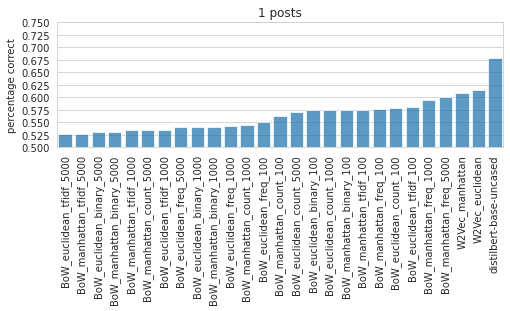

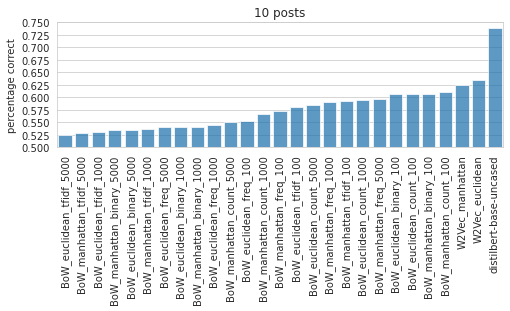

In [85]:
for i in [1,10]:
    plt.subplots(figsize=(8,2.3))
    sns.barplot(data=perf[perf['subset']==i].sort_values(by='performance'),#,.tail(n=50),
                x='id', y='performance',
                color="#0073C2FF",
                alpha=.7)
    plt.xlabel('')
    plt.ylabel('percentage correct')
    plt.xticks(rotation=90)
    plt.yticks(np.arange(.5,.775,.025))
    plt.ylim(.5,.75)
    plt.title(f'{i} posts')
    plt.show()

In [87]:
perf.sort_values(by='performance', ascending=False)

,id,model,subset,metric,performance
52,distilbert-base-uncased,transformer,10,NaN,0.739000
53,distilbert-base-uncased,transformer,1,NaN,0.679000
48,W2Vec_euclidean,Word2Vec,10,euclidean,0.634296
49,W2Vec_manhattan,Word2Vec,10,manhattan,0.624118
50,W2Vec_euclidean,Word2Vec,1,euclidean,0.615461
5,BoW_manhattan_count_100,BoW,10.0,manhattan,0.609930
51,W2Vec_manhattan,Word2Vec,1,manhattan,0.609437
4,BoW_manhattan_binary_100,BoW,10.0,manhattan,0.607728
1,BoW_euclidean_count_100,BoW,10.0,euclidean,0.607636
0,BoW_euclidean_binary_100,BoW,10.0,euclidean,0.607442
